In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from obspy.signal.filter import lowpass
import os
from pathlib import Path

import pyarrow as pa
import pyarrow.parquet as pq
import json

from scipy import signal
from obspy.signal.tf_misfit import cwt
import pywt
from scipy import stats
        
from multiprocessing import Pool, cpu_count

import sys
sys.path.insert(0, os.path.abspath('../../bin/generate_ts'))

from generate_ts_utils import *


In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-3
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [3]:
class vel_ts:
    def __init__(self, array):
        self.array = array
        self.record_number= self.array[0][0]
        #self.meta_dict=make_meta_dict(self.array)

        
    def vel_load_ds(self, target_sr):
        
        path = Path(os.getcwd())
        sm_fn=glob.glob(os.path.join('../../data','ngaw2','RSN%s_*.VT2' %self.record_number))
        scale_f, dt= meta_check(sm_fn[0])
        
        # determine vertical TS
        up_idx=vertical_idx(sm_fn)

        #sort out components- only distinguish between Vert and Horiz for gnss noise
        h_idxs=np.delete(np.arange(3),up_idx)
        h0_idx=h_idxs[0]
        h1_idx=h_idxs[1]

        sr=1/dt
        deci=int(sr/target_sr)
        
        self.H0, self.time, self.H0_y=load_ds_label(sm_fn[h0_idx],sr, deci, buffer45=True)
        self.H1, self.time, self.H1_y=load_ds_label(sm_fn[h1_idx],sr, deci, buffer45=True)
        self.UP, self.time, self.UP_y=load_ds_label(sm_fn[up_idx],sr, deci, buffer45=True)
'''        
def generate_gnss_ts(nga_event_station):
    vel_1=vel_ts(nga_event_station)
    target_sr=5
    vel_1.vel_load_ds(target_sr)

    for noise_lev in np.arange(5,100,15):
        store_df_li=[]
        samples2add=np.random.randint(0,60*5)
        for name,ts,ts_labels in zip(['H0','H1','UP'],[vel_1.H0,vel_1.H1,vel_1.UP],[vel_1.H0_y,vel_1.H1_y,vel_1.UP_y]):
            #add random buffer
            ts,t=add_random_buffer(ts, vel_1.time, samples2add,target_sr)
            ts_labels=np.concatenate((np.zeros(samples2add) ,ts_labels))
            noise_ts=create_noise_ts(n_steps=len(t), level=noise_lev, name=name)
            combined=ts+noise_ts
            #import pandas as pd
            store_df=pd.DataFrame(np.vstack((t,combined, noise_ts, ts_labels.astype(int))).transpose(), 
                            columns=['t','%s_ts' %name,'%s_noise'%name, '%s_label' %name])

            store_df.set_index('t', inplace=True)
            store_df_li.append(store_df)
        write_to_pq(store_df_li, vel_1.array, noise_lev)
'''

"        \ndef generate_gnss_ts(nga_event_station):\n    vel_1=vel_ts(nga_event_station)\n    target_sr=5\n    vel_1.vel_load_ds(target_sr)\n\n    for noise_lev in np.arange(5,100,15):\n        store_df_li=[]\n        samples2add=np.random.randint(0,60*5)\n        for name,ts,ts_labels in zip(['H0','H1','UP'],[vel_1.H0,vel_1.H1,vel_1.UP],[vel_1.H0_y,vel_1.H1_y,vel_1.UP_y]):\n            #add random buffer\n            ts,t=add_random_buffer(ts, vel_1.time, samples2add,target_sr)\n            ts_labels=np.concatenate((np.zeros(samples2add) ,ts_labels))\n            noise_ts=create_noise_ts(n_steps=len(t), level=noise_lev, name=name)\n            combined=ts+noise_ts\n            #import pandas as pd\n            store_df=pd.DataFrame(np.vstack((t,combined, noise_ts, ts_labels.astype(int))).transpose(), \n                            columns=['t','%s_ts' %name,'%s_noise'%name, '%s_label' %name])\n\n            store_df.set_index('t', inplace=True)\n            store_df_li.append(store_df)

In [4]:
vel_1=vel_ts(create_nga_event_station_list(rsn=2499)) #2499
target_sr=5
vel_1.vel_load_ds(target_sr)
name='H0'
noise_lev=50
noise_ts=create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name)

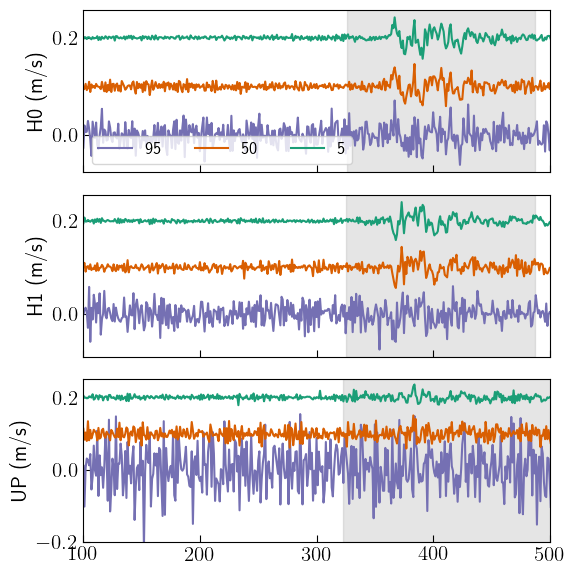

In [6]:
fig,ax=plt.subplots(3,1, sharex=True, figsize=(6,6))

ax[0].axvspan(vel_1.H0_y.nonzero()[0].min(),vel_1.H0_y.nonzero()[0].max(), color='grey', alpha=.2)
ax[1].axvspan(vel_1.H1_y.nonzero()[0].min(),vel_1.H0_y.nonzero()[0].max(), color='grey', alpha=.2)
ax[2].axvspan(vel_1.UP_y.nonzero()[0].min(),vel_1.UP_y.nonzero()[0].max(), color='grey', alpha=.2)
colors=['#7570b3','#d95f02','#1b9e77'][-3:]
levs=[95,50,5][-3:]
for i,(component,name) in enumerate(zip([vel_1.H0,vel_1.H1,vel_1.UP],['H0','H1','UP'])):
    for j,(color,noise_lev) in enumerate(zip(colors,levs)):
        noise_ts=create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name)
        combined=component+noise_ts
        ax[i].plot(combined+.1*j, color=color, label=noise_lev)
        ax[i].set_ylabel('%s (m/s)' %name)
        
        ax[i].set_xlim([100,500])

ax[2].set_ylim([-.2,.25])
ax[0].legend(ncol=3, loc='lower left')
fig.tight_layout()
plt.savefig('figs/example_ts.png',dpi=300)

In [ ]:
plt.plot(500*vel_1.UP)

In [ ]:
plt.plot(combined)

# power point Fig

In [ ]:
fsize = 20
tsize = 20
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-3
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

#plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
fig,ax=plt.subplots(3,1, sharex=True, figsize=(6,6))

ax[0].axvspan(vel_1.H0_y.nonzero()[0].min(),vel_1.H0_y.nonzero()[0].max(), color='grey', alpha=.2)
ax[1].axvspan(vel_1.H1_y.nonzero()[0].min(),vel_1.H0_y.nonzero()[0].max(), color='grey', alpha=.2)
ax[2].axvspan(vel_1.UP_y.nonzero()[0].min(),vel_1.UP_y.nonzero()[0].max(), color='grey', alpha=.2)
colors=['#7570b3','#d95f02','#1b9e77'][-3:]
colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
levs=[95,80,65,50,35,20,5]#[-3:]
for i,(component,name) in enumerate(zip([vel_1.H0,vel_1.H1,vel_1.UP],['H0','H1','UP'])):
    for j,(color,noise_lev) in enumerate(zip(colors,levs)):
        noise_ts=create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name)
        combined=component+noise_ts
        ax[i].plot(combined+.1*j, color=color, label=noise_lev)
        ax[i].set_ylabel('%s (m/s)' %name)
        
        ax[i].set_xlim([250,450])

ax[2].set_ylim([-.2,.7])
ax[2].set_xticks([])#ax[0].legend(ncol=3, loc='lower left')
fig.tight_layout()
plt.savefig('example_ts_pp.png',dpi=300)